<h1>Sentiment analysis:</h1>

Goal: Sentiment analysis is a method for extracting the information from the vast amount of texts. We can understand the feelings ,rate, emotion of a certain service, products like movies, shopping,etc. We can also analyze the reason of this comments and realize what is the next step that we proceed. It can be used to help with decision making. It makes the process easier and more efficient.  

In this practice, we use the dataset from kaggle (https://www.kaggle.com/datasets/miriamodeyianypeter/sentiment-analysis-amazon-product-reviews/data). It is about the comment of a product on amazon. We use it to do the sentiment analysis. By doing so, we can understand the overall rate of a product we are interested in ,and the manufacturers can also know the direction of improving their products and provides better experience or service.

<h2> Main steps:</h2>

1. We will first import our datasets and do some data cleaning

2. Use tokenizer to turn the text data,which is difficult to understand for the computer, to     integers with each represents a word 

3. use padding to make equal length comment (to reduce error and satisfy the input for model)

4. use embedding to change the word to a certain vector to fed to our RNN model  

5. train test split  

6. train RNN network (using simpleRNN,LSTM,GRU to compare)  

7. we can use the model to do further predicts to reduce time  

8. finally, we can try to find out what is the reason and what can we do to improve it for the next  products  



<h3>import library</h3>

In [1]:
import time
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import contractions
import nltk
from nltk.corpus import stopwords
import ssl
#allow for skipping SSL validation temporarly
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Dropout
from tensorflow.keras.layers import SimpleRNN,LSTM,GRU
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /Users/wayne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h3>load data

In [ ]:
data=pd.read_csv('Amazon product review.csv')
data

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30841,US,44834233,R366C7ARIWLN7R,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,3720,3875,N,Y,A great upgrade for me from an older Kindle Fire!,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,2014-10-03,1
30842,US,13376158,R35PL0AOCUXLU9,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,2716,2849,N,Y,Great Value for $139,I'm writing this review with the benefit of be...,2014-10-03,1
30843,US,40485963,R18ZJVY86AUFII,B00KC6XV58,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1525,1629,N,Y,Even grandma has it figured out!,"I purchased this Kindle for my grandma, becaus...",2014-10-03,1
30844,US,33485035,R36QVLQXMCZRSJ,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,143,163,N,Y,The Honda Accord of Tablets,I bought my tablet Fire HD 7 at Best Buy on th...,2014-10-03,1


<h3>comment preprocessing</h3>

In [4]:
#preprocessing
#turn into lower case
data['review_body'] = data['review_body'].astype(str).str.lower()

#delete <br>,<p> html tag
data['review_body'] = data['review_body'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())

#delete number,comma,punctuation mark or special characters,emogi
data['review_body'] = data['review_body'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

#remove extra space
data['review_body'] = data['review_body'].apply(lambda x: " ".join(x.split()))

#return words without contraction (縮寫) like it's-->it is
data['review_body'] = data['review_body'].apply(lambda x: contractions.fix(x))

#remove stopwords(停用詞)(common words that is not important like the,is,are,I)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
data['review_body'] = data['review_body'].apply(lambda x: " ".join(
    [word for word in x.split() if word not in stop_words]))

#lemmatization(詞性還原)like running->run/better->good
lemmatizer = WordNetLemmatizer()
data['review_body'] = data['review_body'].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

/var/folders/nn/1k4ph2995ylfc8r0v3_pftj80000gn/T/ipykernel_18762/4164159811.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data['review_body'] = data['review_body'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
[nltk_data] Downloading package stopwords to /Users/wayne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#result
data['review_body']

0                                               great love
1        lot adsslow processing speedoccasionally shuts...
2        excellent unit versatility tablet besides comp...
3        bought amazon prime ended buying gb one camera...
4                 amazon product continue meet expectation
                               ...                        
30841    videoidmopbgsrllyi purchased original kindle f...
30842    writing review benefit experienced kindle fire...
30843    purchased kindle grandma wanted simple way vid...
30844    bought tablet fire hd best buy day came planne...
30845     impressive piece hardware regret girlfriend love
Name: review_body, Length: 30846, dtype: object

<h3>Tokenizer:</h3>  

turn the text data to numeric integer sequences

In [6]:
tokenizer=Tokenizer(num_words=10000,oov_token="<OOV>")
tokenizer.fit_on_texts(data['review_body'])
data['review_body'] = tokenizer.texts_to_sequences(data['review_body'])
len(tokenizer.word_index)

18885

we select 10000 words out of 18885 words in total and left the rest of 8885 words be replaced by OOV(out of vacabulary) number

In [7]:
tokenizer.word_index

{'<OOV>': 1,
 'love': 2,
 'kindle': 3,
 'fire': 4,
 'great': 5,
 'tablet': 6,
 'one': 7,
 'use': 8,
 'like': 9,
 'hd': 10,
 'amazon': 11,
 'would': 12,
 'book': 13,
 'get': 14,
 'good': 15,
 'device': 16,
 'easy': 17,
 'new': 18,
 'apps': 19,
 'time': 20,
 'screen': 21,
 'much': 22,
 'work': 23,
 'really': 24,
 'bought': 25,
 'product': 26,
 'thing': 27,
 'old': 28,
 'still': 29,
 'read': 30,
 'price': 31,
 'game': 32,
 'reading': 33,
 'first': 34,
 'also': 35,
 'cannot': 36,
 'better': 37,
 'year': 38,
 'got': 39,
 'could': 40,
 'battery': 41,
 'far': 42,
 'well': 43,
 'need': 44,
 'everything': 45,
 'nice': 46,
 'gift': 47,
 'even': 48,
 'play': 49,
 'happy': 50,
 'camera': 51,
 'app': 52,
 'day': 53,
 'picture': 54,
 'little': 55,
 'want': 56,
 'lot': 57,
 'buy': 58,
 'problem': 59,
 'go': 60,
 'ipad': 61,
 'purchase': 62,
 'back': 63,
 'take': 64,
 'feature': 65,
 'prime': 66,
 'using': 67,
 'video': 68,
 'kid': 69,
 'movie': 70,
 'quality': 71,
 'used': 72,
 'purchased': 73,
 'siz

In [8]:
data['review_body']

0                                                   [5, 2]
1        [57, 7618, 1131, 7619, 1042, 7620, 131, 3420, ...
2        [102, 245, 1373, 6, 1132, 7622, 975, 1144, 195...
3        [25, 11, 66, 746, 259, 101, 7, 51, 594, 2, 163...
4                                  [11, 26, 757, 460, 193]
                               ...                        
30841    [1, 73, 136, 3, 4, 145, 155, 3, 4, 239, 136, 7...
30842    [1178, 215, 1054, 1270, 3, 4, 110, 1043, 404, ...
30843    [73, 3, 1459, 93, 326, 77, 68, 1047, 28, 738, ...
30844    [25, 6, 4, 10, 86, 58, 53, 209, 1801, 11, 1039...
30845                       [1382, 573, 825, 856, 1363, 2]
Name: review_body, Length: 30846, dtype: object

<h3>Padding:</h3>

Padding is a techniques that makes the comments the same length. Each comment has a length of maxlen. If greater than it, the comment will be cut into maxlen long and if less than it the function will fill in certain value (usually 0) to make the equal length.

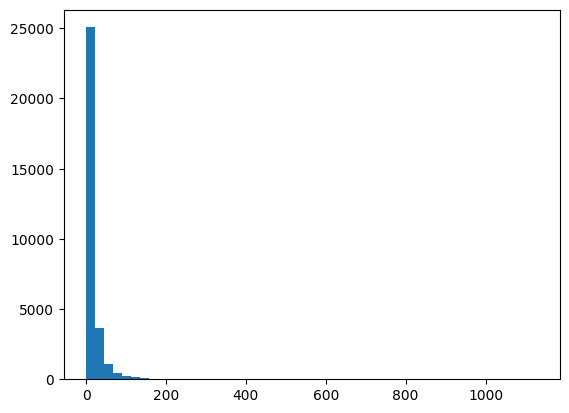

In [9]:
sequence_lengths = [len(seq) for seq in data['review_body']]
plt.hist(sequence_lengths, bins=50)
plt.show()

from the graph we see the comments are usually less than 50 words so we will choose 50 as our maxlen

In [10]:
data['review_body'] =list(pad_sequences(data['review_body'], maxlen=50))
data['review_body']

0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [3169, 551, 67, 3421, 252, 65, 665, 110, 534, ...
3        [1374, 7, 3, 13, 167, 85, 35, 7, 438, 212, 73,...
4        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
30841    [85, 11, 289, 7610, 3293, 2971, 3025, 66, 169,...
30842    [190, 404, 24, 361, 68, 19, 65, 69, 2, 30, 13,...
30843    [19, 62, 52, 1459, 213, 178, 133, 3, 556, 289,...
30844    [1008, 3455, 1051, 71, 2444, 1, 633, 41, 83, 7...
30845    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: review_body, Length: 30846, dtype: object

<h3>train,test split</h3>

In [11]:
x = np.array(data['review_body'].tolist())
y=data['sentiment']

In [12]:
#I will use 20% as test data
X_train,X_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=42)

<h3>Model Building</h3>



Next, I will use embedding to change each word to certain vector and use rnn model(simple rnn,LSTM,GRU) to compare the result

SimpleRNN:

In [13]:
start=time.time()
model=Sequential([
    Embedding(input_dim=10000,output_dim=128,input_length=50),
    SimpleRNN(64, activation='relu'),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid'),
])
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=32,epochs=10,validation_split=0.2)
end=time.time()
print(f"training time: {end - start:.2f} seconds")

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


617/617 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8197 - loss: 0.4877 - val_accuracy: 0.8389 - val_loss: 0.2955
Epoch 2/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8624 - loss: 0.2824 - val_accuracy: 0.8934 - val_loss: 0.2528
Epoch 3/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9133 - loss: 0.2104 - val_accuracy: 0.9030 - val_loss: 0.2427
Epoch 4/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9292 - loss: 0.1817 - val_accuracy: 0.8993 - val_loss: 0.2481
Epoch 5/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9438 - loss: 0.1549 - val_accuracy: 0.8880 - val_loss: 0.2700
Epoch 6/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9506 - loss: 0.1370 - val_accuracy: 0.9009 - val_loss: 0.2686
Epoch 7/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9595 - loss: 0.1153 - val_accuracy: 0.9021 - val_loss: 0.3010
Epoch 8/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9673 - loss: 0.1000 - val_accuracy: 0.901

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"test_loss: {loss:.4f}, test_accuracy: {accuracy:.4f}")
result=[]
result.append(pd.Series({'test_loss': loss,'test_accuracy':accuracy,'time':f'{end - start:.2f}'},name='simplernn'))

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8993 - loss: 0.3341
test_loss: 0.3691, test_accuracy: 0.8964


LSTM:

In [15]:
start=time.time()
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=50),
    LSTM(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train,batch_size=32,epochs=10,validation_split=0.2)
end=time.time()
print(f"training time: {end - start:.2f} seconds")

Epoch 1/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8160 - loss: 0.4901 - val_accuracy: 0.8371 - val_loss: 0.3658
Epoch 2/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8531 - loss: 0.3285 - val_accuracy: 0.8961 - val_loss: 0.2511
Epoch 3/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.9092 - loss: 0.2309 - val_accuracy: 0.8985 - val_loss: 0.2439
Epoch 4/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9186 - loss: 0.2141 - val_accuracy: 0.9036 - val_loss: 0.2348
Epoch 5/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9293 - loss: 0.1888 - val_accuracy: 0.9072 - val_loss: 0.2380
Epoch 6/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9344 - loss: 0.1725 - val_accuracy: 0.9072 - val_loss: 0.2679
Epoch 7/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9435 - loss: 0.1556 - val_accuracy: 0.9054 - val_loss: 1.6195
Epoch 8/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9464 - loss: 0.1472 - 

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"test_loss: {loss:.4f}, test_accuracy: {accuracy:.4f}")
result.append(pd.Series({'test_loss': loss,'test_accuracy':accuracy,'time':f'{end - start:.2f}'},name='LSTM'))

193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9067 - loss: 0.2600
test_loss: 0.2974, test_accuracy: 0.9006


GRU:

In [17]:
start = time.time()
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=50),
    GRU(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)
end = time.time()
print(f"training time: {end - start:.2f} seconds")

Epoch 1/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.8342 - loss: 0.4929 - val_accuracy: 0.8408 - val_loss: 0.3204
Epoch 2/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8805 - loss: 0.2695 - val_accuracy: 0.9005 - val_loss: 0.2437
Epoch 3/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9162 - loss: 0.2086 - val_accuracy: 0.9024 - val_loss: 0.2388
Epoch 4/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9330 - loss: 0.1794 - val_accuracy: 0.9038 - val_loss: 0.2423
Epoch 5/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9390 - loss: 0.1702 - val_accuracy: 0.9007 - val_loss: 0.2537
Epoch 6/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9441 - loss: 0.1562 - val_accuracy: 0.9005 - val_loss: 0.2767
Epoch 7/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9571 - loss: 0.1318 - val_accuracy: 0.8983 - val_loss: 0.2867
Epoch 8/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9580 - loss: 0.1265 - 

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"test_loss: {loss:.4f}, test_accuracy: {accuracy:.4f}")
result.append(pd.Series({'test_loss': loss, 'test_accuracy': accuracy,'time':f'{end - start:.2f}'},name='GRU'))

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8986 - loss: 0.4059
test_loss: 0.4417, test_accuracy: 0.8948


In [19]:
results = pd.concat(result, axis=1)
results

,simplernn,LSTM,GRU
test_loss,0.369073,0.297372,0.441721
test_accuracy,0.896434,0.900648,0.894814
time,65.43,226.76,203.32


By comparing, we know that simplernn,LSTM,GRU RNN model performs almost equally on the test set. They have similar accuracy ~~90%. But LSTM have much less loss than the other two. This might because it is better on the long comments. However, it also takes the longest time to train. 

<h3>Next:</h3>

I want to use other methods to understand what cause the positive and negative comments,I will use shap and wordcloud to analyze it.

Shap:

In [24]:
import os
import numpy as np
import shap
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from wordcloud import WordCloud
import random

Wordcloud:

In [85]:
y_pred_label = ((model.predict(X_test) > 0.5).astype(int) )[:500] # 轉為 0/1 類別

# 計算 SHAP 值
explainer = shap.Explainer(model, X_train[:500])
shap_values = explainer(X_test[:500])

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


PermutationExplainer explainer: 501it [21:32,  2.60s/it]                         


對正類預測積極影響最大的詞: ['downside', 'quicker', 'although', 'packaged', 'bonus', 'stable', 'teach', 'imagined', 'feb', 'winner', 'visiting', 'borrow', 'purple', 'knock', 'budget', 'monster', 'watched', 'awesome', 'channel', 'comment']
對負類預測積極影響最大的詞: ['broken', 'thirty', 'freezing', 'happening', 'unresponsive', 'proper', 'supervisor', 'miss', 'returned', 'ridiculous', 'rude', 'junk', 'horizontal', 'twice', 'stopped', 'rest', 'turning', 'join', 'unknown', 'understand']


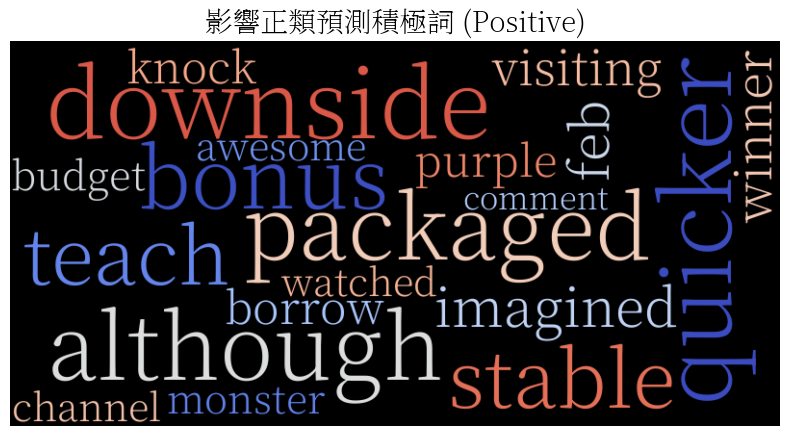

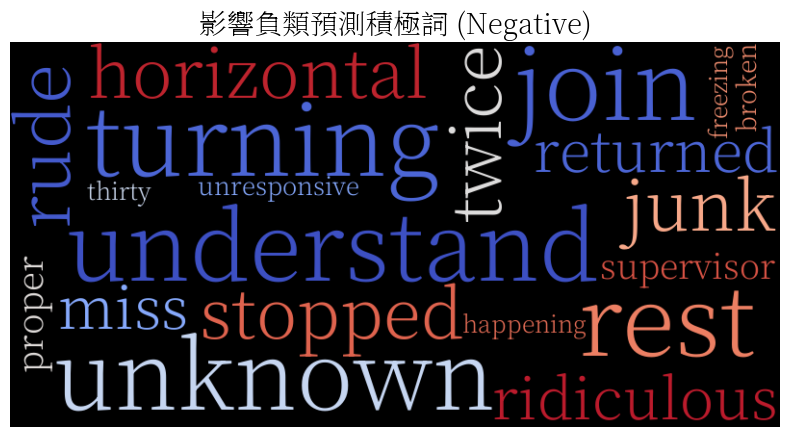

In [117]:
# 建立字典來儲存正負類別的 SHAP 值
word_shap_values_pos = defaultdict(list)  # 預測為正類時的 SHAP 值
word_shap_values_neg = defaultdict(list)  # 預測為負類時的 SHAP 值

vocab = tokenizer.index_word  # Token ID → 文字

# 遍歷每條評論
for sample_idx, sample in enumerate(X_test[:500]):
    pred_class = y_pred_label[sample_idx][0]  # 取得該評論的預測類別 (0: 負, 1: 正)

    for pos, word_idx in enumerate(sample):
        if word_idx != 0:  # 忽略 padding
            word = vocab.get(word_idx, "[UNK]")  # 取得對應的詞
            shap_value = shap_values.values[sample_idx, pos]  # 取得該詞的 SHAP 值

            # 依預測類別分類
            if pred_class == 1:
                word_shap_values_pos[word].append(shap_value)  # 正類別評論
            else:
                word_shap_values_neg[word].append(shap_value)  # 負類別評論

# 計算每個詞的 SHAP 平均值
word_shap_mean_pos = {word: np.mean((shap_vals))
                      for word, shap_vals in word_shap_values_pos.items()}
word_shap_mean_neg = {word: np.mean((shap_vals))
                      for word, shap_vals in word_shap_values_neg.items()}

# 選擇對正類預測積極影響最大的詞
top_positive_words = sorted(
    [(word, np.mean(shap_vals))
     for word, shap_vals in word_shap_values_pos.items() if np.mean(shap_vals) > 0],
    key=lambda x: x[1], reverse=True
)[:20]

# 選擇對負類預測積極影響最大的詞
top_negative_words = sorted(
    [(word, np.mean(shap_vals))
     for word, shap_vals in word_shap_values_neg.items() if np.mean(shap_vals) < 0],
    key=lambda x: x[1]
)[:20]

# 顯示關鍵詞
print("對正類預測積極影響最大的詞:", [word for word, _ in top_positive_words])
print("對負類預測積極影響最大的詞:", [word for word, _ in top_negative_words])

# 生成詞雲所需的數據
filtered_wordcloud_data_pos = {word: shap for word, shap in top_positive_words}
filtered_wordcloud_data_neg = {word: shap for word, shap in top_negative_words}

# 自定義背景顏色和字體設置
font_path = "/Users/wayne/Desktop/IBM/machine learning/deep learning /final/NotoSerifTC.ttf"  # 字體路徑

# 生成正類詞雲（顯示對正類預測的積極影響詞）
wordcloud_pos = WordCloud(
    width=800,
    height=400,
    background_color="black",  # 背景色（黑色）
    font_path=font_path,  # 字體設置
    max_words=200,  # 顯示最多200個詞
    min_font_size=20,  # 最小字體大小
    max_font_size=100,  # 最大字體大小
    contour_color="black",  # 邊框顏色
    contour_width=2,  # 邊框寬度
    colormap="coolwarm",  # 顏色圖（從冷到暖的顏色映射）
    prefer_horizontal=0.5,  # 讓文本更偏向水平排列
).generate_from_frequencies(filtered_wordcloud_data_pos)

# 顯示正類影響詞雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("影響正類預測積極詞 (Positive)", fontsize=20, fontweight='bold')  # 標題設置
plt.show()

# 生成負類詞雲（顯示對負類預測的積極影響詞）
wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color="black",  # 背景色（黑色）
    font_path=font_path,  # 字體設置
    max_words=200,  # 顯示最多200個詞
    min_font_size=20,  # 最小字體大小
    max_font_size=100,  # 最大字體大小
    contour_color="black",  # 邊框顏色
    contour_width=2,  # 邊框寬度
    colormap="coolwarm",  # 顏色圖（Viridis 色條）
    prefer_horizontal=0.5,  # 讓文本更偏向水平排列
).generate_from_frequencies(filtered_wordcloud_data_neg)

# 顯示負類影響詞雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("影響負類預測積極詞 (Negative)", fontsize=20, fontweight='bold')  # 標題設置
plt.show()

matplotlib:

对正类预测积极影响最大的词: ['downside', 'quicker', 'although', 'packaged', 'bonus', 'stable', 'teach', 'imagined', 'feb', 'winner', 'visiting', 'borrow', 'purple', 'knock', 'budget', 'monster', 'watched', 'awesome', 'channel', 'comment']
对负类预测积极影响最大的词: ['broken', 'thirty', 'freezing', 'happening', 'unresponsive', 'proper', 'supervisor', 'miss', 'returned', 'ridiculous', 'rude', 'junk', 'horizontal', 'twice', 'stopped', 'rest', 'turning', 'join', 'unknown', 'understand']


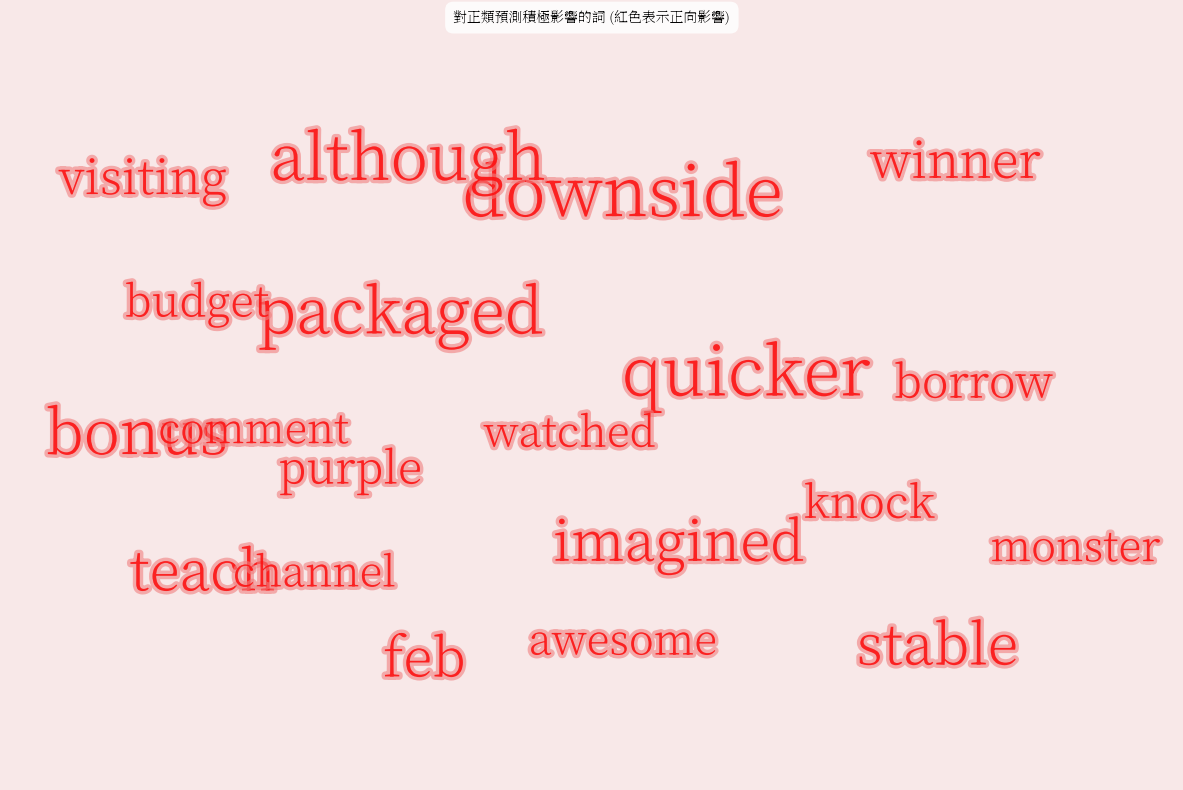

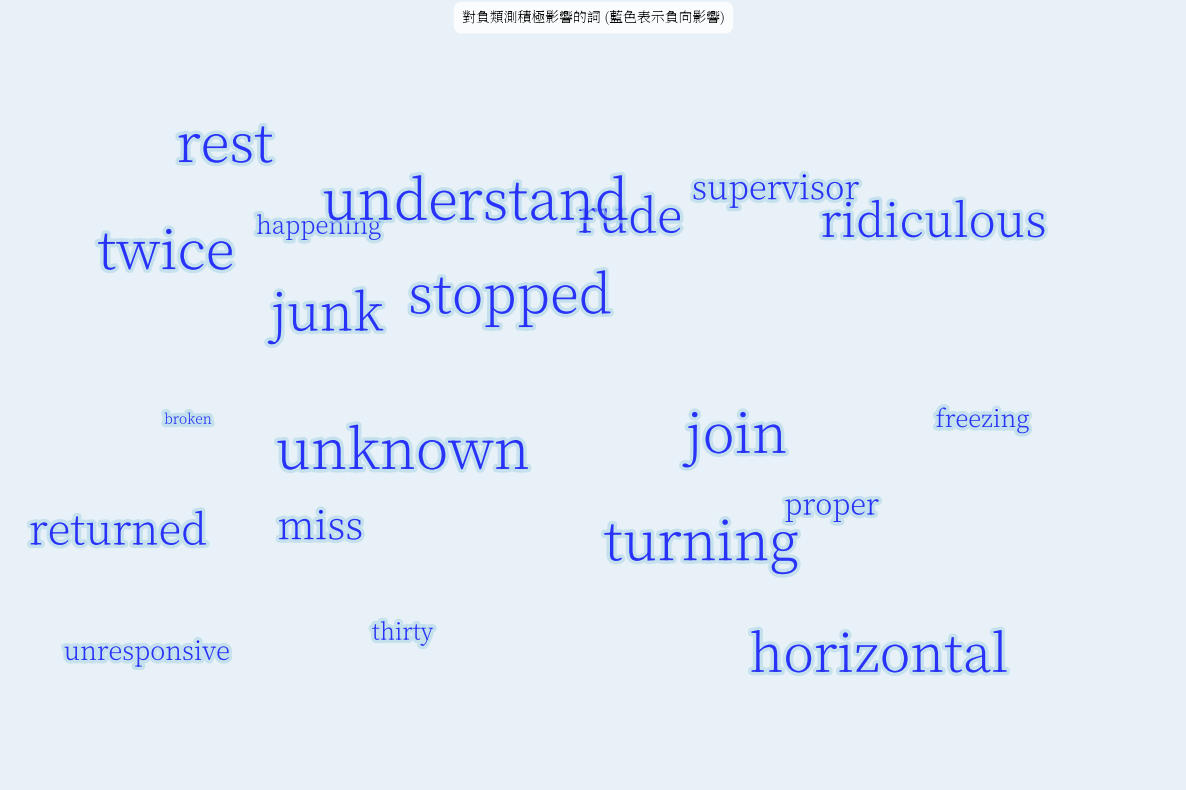

In [139]:
import matplotlib.patheffects as path_effects  # 確保導入 path_effects
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from matplotlib import font_manager

# 创建字典来储存正负类的 SHAP 值
word_shap_values_pos = defaultdict(list)  # 预测为正类时的 SHAP 值
word_shap_values_neg = defaultdict(list)  # 预测为负类时的 SHAP 值

vocab = tokenizer.index_word  # Token ID -> 词

# 遍历每条评论，计算每个词的 SHAP 值
for sample_idx, sample in enumerate(X_test[:500]):
    pred_class = y_pred_label[sample_idx][0]  # 取得该评论的预测类别 (0: 负, 1: 正)

    for pos, word_idx in enumerate(sample):
        if word_idx != 0:  # 忽略 padding
            word = vocab.get(word_idx, "[UNK]")  # 取得对应的词
            shap_value = shap_values.values[sample_idx, pos]  # 取得该词的 SHAP 值

            # 根据预测类别分类
            if pred_class == 1:
                word_shap_values_pos[word].append(shap_value)  # 正类评论
            else:
                word_shap_values_neg[word].append(shap_value)  # 负类评论

# 计算每个词的 SHAP 平均值
word_shap_mean_pos = {word: np.mean(shap_vals)
                      for word, shap_vals in word_shap_values_pos.items()}
word_shap_mean_neg = {word: np.mean(shap_vals)
                      for word, shap_vals in word_shap_values_neg.items()}

# 选择对正类预测积极影响最大的词
top_positive_words = sorted(
    [(word, np.mean(shap_vals))
     for word, shap_vals in word_shap_values_pos.items() if np.mean(shap_vals) > 0],
    key=lambda x: x[1], reverse=True
)[:20]  # 选择显示前50个词

# 选择对负类预测积极影响最大的词
top_negative_words = sorted(
    [(word, np.mean(shap_vals))
     for word, shap_vals in word_shap_values_neg.items() if np.mean(shap_vals) < 0],
    key=lambda x: x[1]
)[:20]  # 选择显示前50个词

# 显示关键词
print("对正类预测积极影响最大的词:", [word for word, _ in top_positive_words])
print("对负类预测积极影响最大的词:", [word for word, _ in top_negative_words])

# 设置字体路径
font_path = os.path.join(os.getcwd(), 'NotoSerifTC.ttf')  # 替换为你的字体路径
font_prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
plt.rcParams['axes.unicode_minus'] = False  # 防止负号显示异常


def generate_non_overlapping_coordinates(n, x_range=(0.08, 0.92), y_range=(0.15, 0.85), min_distance=0.12):
    """生成不重叠的随机坐标"""
    coordinates = []
    max_attempts = 3000
    attempts = 0

    while len(coordinates) < n and attempts < max_attempts:
        x = random.uniform(*x_range)
        y = random.uniform(*y_range)

        if all(np.linalg.norm(np.array([x, y]) - np.array(c)) > min_distance for c in coordinates):
            coordinates.append([x, y])
        else:
            attempts += 1

        if attempts >= max_attempts * 0.8:
            min_distance *= 0.9

    while len(coordinates) < n:
        coordinates.append(
            [random.uniform(*x_range), random.uniform(*y_range)])

    return np.array(coordinates)


def plot_shap_wordcloud(words, title, color, glow_color, background_color, min_font=30, max_font=100, min_distance=0.12):
    """绘制 SHAP 词云，带有发光效果"""
    coordinates = generate_non_overlapping_coordinates(
        len(words), min_distance=min_distance)
    fig, ax = plt.subplots(figsize=(12, 8))

    # 设置整张图的背景色
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    # 调整字体大小范围，避免极端数值
    shap_values = np.array([val for _, val in words])
    if len(shap_values) > 0:
        min_shap, max_shap = min(shap_values), max(shap_values)
        if min_shap != max_shap:
            sizes = min_font + (shap_values - min_shap) / \
                (max_shap - min_shap) * (max_font - min_font)
        else:
            sizes = [min_font] * len(words)  # 所有 SHAP 值相等时，给予统一大小
    else:
        sizes = [min_font] * len(words)

    for i, (word, shap_value) in enumerate(words):
        alpha = max(0.7, min(1, abs(shap_value) * 1.2))
        text_color = (*color, alpha)

        ax.text(coordinates[i][0], coordinates[i][1], word,
                fontsize=sizes[i], color=text_color, ha='center', va='center',
                fontproperties=font_prop, path_effects=[
                    path_effects.Stroke(
                        linewidth=5, foreground=glow_color, alpha=0.6),
                    path_effects.Normal()
        ])

    # 设置标题
    ax.set_title(title, fontsize=32, fontweight='bold', fontproperties=font_prop,
                 bbox=dict(facecolor='white', alpha=0.85, edgecolor='none', boxstyle='round,pad=0.6'))

    ax.axis('off')
    plt.tight_layout()
    plt.show()


# 绘制正类积极影响词云（红色）
plot_shap_wordcloud(top_positive_words, "對正類預測積極影響的詞 (紅色表示正向影響)",
                    color=(1, 0, 0), glow_color='lightcoral', background_color='#F8E8E8',
                    min_font=30, max_font=50, min_distance=0.17)

# 绘制负类积极影响词云（蓝色）
plot_shap_wordcloud(top_negative_words, "對負類測積極影響的詞 (藍色表示負向影響)",
                    color=(0, 0, 1), glow_color='lightblue', background_color='#E8F0F8',
                    min_font=10, max_font=40, min_distance=0.12)

I use two methods to create my wordcloud, wordcloud and matplotlib. This is because the wordcloud 

library pops up the ttf problems. As you can see, the wordcloud makes better and prettier graphs 

and it has easier parameters to adjust your plot. The results show that the words that affect the 

positive emotions are stable,quicker,packaged,bonus,etc. For the negative emotions we have broken,

ridiculous,rude,junk,unresponsive.

We can see that some words might be associated with positive or negative comments, but we still 

can't really understand what happen. To further dicuss it, we can see what words combinations usually go with 

these words . To do so, I will continue using ngrams and spacy to analyze the most common word combinations in the positive  
  
and negative category.

<h3>Ngrams:</h3>  

Ngrams is used to see how frequent a certain word combinations appears in the comments. 
  
We can use ngrams to see what causes positive,negative comments, since appear more frequently the more likely is the

main  reasons.

In [53]:
# reimport comments
data1 = pd.read_csv('Amazon product review.csv')

In [54]:
# preprocessing
# turn into lower case
data1['review_body'] = data1['review_body'].astype(str).str.lower()

# delete <br>,<p> html tag
data1['review_body'] = data1['review_body'].apply(
    lambda x: BeautifulSoup(x, "html.parser").get_text())

# delete number,comma,punctuation mark or special characters,emogi
data1['review_body'] = data1['review_body'].apply(
    lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# remove extra space
data1['review_body'] = data1['review_body'].apply(lambda x: " ".join(x.split()))

# return words without contraction (縮寫) like it's-->it is
data1['review_body'] = data1['review_body'].apply(lambda x: contractions.fix(x))

# remove stopwords(停用詞)(common words that is not important like the,is,are,I)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
data1['review_body'] = data1['review_body'].apply(lambda x: " ".join(
    [word for word in x.split() if word not in stop_words]))

# lemmatization(詞性還原)like running->run/better->good
lemmatizer = WordNetLemmatizer()
data1['review_body'] = data1['review_body'].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

/var/folders/nn/1k4ph2995ylfc8r0v3_pftj80000gn/T/ipykernel_24408/3902992104.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda x: BeautifulSoup(x, "html.parser").get_text())
[nltk_data] Downloading package stopwords to /Users/wayne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
positive_reviews = data1[data1['sentiment'] == 1]['review_body']
negative_reviews = data1[data1['sentiment'] ==0]['review_body']

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
# 進行 N-grams 分析
from nltk.util import ngrams

# 使用 N-grams 提取
positive_vectorizer = CountVectorizer(ngram_range=(2,2), min_df=5, max_df=0.9)
negative_vectorizer = CountVectorizer(ngram_range=(2,2), min_df=5, max_df=0.9)

# 轉換文本為稀疏矩陣
X_pos = positive_vectorizer.fit_transform(positive_reviews)
X_neg = negative_vectorizer.fit_transform(negative_reviews)

# 提取 n-grams 頻率
ngram_freq_pos = pd.DataFrame(
    {'n-gram': positive_vectorizer.get_feature_names_out(),
     'Positive Frequency': X_pos.toarray().sum(axis=0)}
).sort_values(by='Positive Frequency', ascending=False)

ngram_freq_neg = pd.DataFrame(
    {'n-gram': negative_vectorizer.get_feature_names_out(),
     'Negative Frequency': X_neg.toarray().sum(axis=0)}
).sort_values(by='Negative Frequency', ascending=False)

# 顯示最高頻的 n-grams
print("📌 最常見的正面 n-grams:")
print(ngram_freq_pos.head(50))

print("\n📌 最常見的負面 n-grams:")
print(ngram_freq_neg.head(50))

📌 最常見的正面 n-grams:
               n-gram  Positive Frequency
239       kindle fire                 291
127           fire hd                 247
100          easy use                 113
300       love kindle                 105
334        new kindle                  78
389         prime day                  71
203     great product                  60
304          love new                  55
15       amazon prime                  54
30       battery life                  53
525          year old                  52
295         love fire                  50
510        work great                  48
333          new fire                  42
343        old kindle                  42
415       really like                  41
446    still learning                  39
302         love love                  38
209      great tablet                  38
202       great price                  36
405         read book                  34
361   original kindle                  33
371         play

<h3>Spacy:</h3>  

However,sometimes, more frequent words might not show ideas or reasons, so some other methods can  

also be used, like spacy(a powerful NLP library). Spacy is like ngrams, it will show the most 

frequent words in the positive and negative categories. But it is more powerful than ngrams. 

Unlike  ngrams, which just split the words and find the nearest vocab. Spacy will also tag each 

words with types: like nouns, verbs,adjectives and show a more meaning analysis or pictures of the 

reasons.

In [94]:
import spacy
from collections import Counter

# 加載spaCy語言模型
nlp = spacy.load('en_core_web_sm')

# 選擇前3000條正面和負面評論，並跳過非字符串的評論
positive_reviews = data1[data1['sentiment'] == 1]['review_body'].apply(lambda x: x if isinstance(x, str) else None)[:2500]
negative_reviews = data1[data1['sentiment'] == 0]['review_body'].apply(lambda x: x if isinstance(x, str) else None)[:2500]

# 進行文本清理，去除 None 值（這是非字符串的項目）
positive_reviews = positive_reviews.dropna()
negative_reviews = negative_reviews.dropna()

# 合併所有正面和負面評論的文字
positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# 使用spaCy進行分詞
positive_doc = nlp(positive_text)
negative_doc = nlp(negative_text)

# 提取雙詞組（bigram）
def extract_bigrams(doc):
    # 提取名詞、形容詞和動詞的雙詞組
    bigrams = [f"{token1.text} {token2.text}" for token1, token2 in zip(doc, doc[1:]) if token1.pos_ in ["NOUN", "ADJ", "VERB"] and token2.pos_ in ["NOUN", "ADJ", "VERB"]]
    return bigrams

# 提取雙詞組
positive_bigrams = extract_bigrams(positive_doc)
negative_bigrams = extract_bigrams(negative_doc)

# 使用Counter計算出現頻率
positive_bigram_counts = Counter(positive_bigrams)
negative_bigram_counts = Counter(negative_bigrams)

# 打印最常見的雙詞組
print("📌 影響好評的核心詞組:", positive_bigram_counts.most_common(20))
print("📌 影響差評的核心詞組:", negative_bigram_counts.most_common(20))

📌 影響好評的核心詞組: [('kindle fire', 259), ('fire hd', 231), ('easy use', 111), ('love love', 74), ('prime day', 71), ('great product', 61), ('love kindle', 58), ('new kindle', 54), ('battery life', 53), ('year old', 52), ('love fire', 51), ('work great', 46), ('love new', 46), ('new fire', 42), ('old kindle', 37), ('great price', 36), ('amazon prime', 33), ('love great', 31), ('original kindle', 30), ('play game', 29)]
📌 影響差評的核心詞組: [('kindle fire', 363), ('fire hd', 294), ('battery life', 159), ('customer service', 125), ('old kindle', 68), ('play store', 66), ('app store', 62), ('year old', 53), ('original kindle', 45), ('prime day', 42), ('new kindle', 40), ('hold charge', 40), ('user friendly', 36), ('special offer', 36), ('home screen', 35), ('lock screen', 34), ('android tablet', 33), ('reading book', 33), ('battery last', 31), ('play game', 30)]


In [95]:
positive_bigram_counts.most_common(20)

[('kindle fire', 259),
 ('fire hd', 231),
 ('easy use', 111),
 ('love love', 74),
 ('prime day', 71),
 ('great product', 61),
 ('love kindle', 58),
 ('new kindle', 54),
 ('battery life', 53),
 ('year old', 52),
 ('love fire', 51),
 ('work great', 46),
 ('love new', 46),
 ('new fire', 42),
 ('old kindle', 37),
 ('great price', 36),
 ('amazon prime', 33),
 ('love great', 31),
 ('original kindle', 30),
 ('play game', 29)]

In [96]:
negative_bigram_counts.most_common(20)

[('kindle fire', 363),
 ('fire hd', 294),
 ('battery life', 159),
 ('customer service', 125),
 ('old kindle', 68),
 ('play store', 66),
 ('app store', 62),
 ('year old', 53),
 ('original kindle', 45),
 ('prime day', 42),
 ('new kindle', 40),
 ('hold charge', 40),
 ('user friendly', 36),
 ('special offer', 36),
 ('home screen', 35),
 ('lock screen', 34),
 ('android tablet', 33),
 ('reading book', 33),
 ('battery last', 31),
 ('play game', 30)]

<h3>Result:</h3>  
With the ngrams and spacy, we could find that:   

1.The product we are having here is kindle fire, a tablet released by amazon.   

2.The customers are satisfied with the experience of the tablets, it is easy to use, it may has discounts and sells cheaper on amazon prime day.    

3.However, some points that make customers unsatisfied are the battery problems(maybe because battery last time),customer service, and the apple store(amazon develops by itself not using GoogleStore or Appstore from apple), the diversity and choices of apps and games may be limited.
Maybe for some users, lock screen is another issue.  

4.Connect to the wordcloud above, we can say that the bonus might be related to the amazon prime activities and the rude or unresponsive might refer to the customer service of amazon.    

5.With wordcloud and ngrams or spacy, we can have a bigger picture of how a certain products is, we can use this information to understand the overall rate of it and draw new solutions or improvements for the next version.


<h3>What's Next:</h3>    

1.We can use it to build a recommendation systems or analyze systems of a certain products and expand the idea into other usages like: movie,trip choice, etc.   

2.In addition to the comments from others, we can learn how to build a recommendation systems using personal preferences , viewing times or clicking times.  
